In [1]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import pandas as pd
import math

# TMDB developer keys are available for free from TMDB: https://developers.themoviedb.org/3/getting-started/introduction

def tmdb_keyword_query(kw_list, api_key):

    """
    Uses the TMDB Web API to generate list of movie ids based on keyword search.
    :param kw_list: list of keyword strings
    :param api_key: API key string
    :return: list of unique ids
    """

    # return keyword ids and store them as a pipe-delimited string

    kw_id_list=[]

    for kw in kw_list:
        url = 'https://api.themoviedb.org/3/search/keyword?api_key={key}&query={query}'\
                 .format(key=api_key, query=kw)

        session = Session()

        try:
          response = session.get(url)
          kw_ids = json.loads(response.text)

        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)

        df = pd.json_normalize(kw_ids['results'])
        kw_ids = list(df['id'])
        kw_ids = [str(kw_id) for kw_id in kw_ids]
        for kw_id in kw_ids:
            kw_id_list.append(kw_id)

    piped_ids = '|'.join(kw_id_list)

    # return first page of results, check total page count for all results, and set page range maximum

    url = '''https://api.themoviedb.org/3/discover/movie?with_keywords={ids}
            &page={page_num}
            &api_key={key}&'''.format(ids=piped_ids, page_num=1, key=api_key)

    session = Session()

    try:
      response = session.get(url)
      kw_data = json.loads(response.text)
      page_max = kw_data['total_pages']+1

    except (ConnectionError, Timeout, TooManyRedirects) as e:
      print(e)

    # loop through page range to generate list of movie ids

    id_list = []
    for p in range(1,page_max):
        url = '''https://api.themoviedb.org/3/discover/movie?with_keywords={ids}
            &page={page_num}
            &api_key={key}&'''.format(ids=piped_ids, page_num=p, key=api_key)

        session = Session()

        try:
          response = session.get(url)
          kw_data = json.loads(response.text)
        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)

        kw_df = pd.json_normalize(kw_data['results'])
        id_list.append(kw_df['id'])

    id_list = [i_list for i in id_list for i_list in i]

    # estimate time to build dataset

    time_estimate = math.ceil(len(id_list) * 0.002)

    print('It will take about {} minute(s) to build this dataset based on {} movies. Proceed?'.format(time_estimate, f'{len(id_list):,d}'))
    return id_list


def build_dataset(id_list, api_key):
    """
    Builds dataset using TMDB web API
    :param id_list: list of TMDB unique ids
    :param api_key:
    :return: Pandas Dataframe
    """

    data_dict = {}
    for id in id_list:
        url = 'https://api.themoviedb.org/3/movie/{movie_id}?api_key={key}'.format(movie_id=id, key=api_key)

        session = Session()

        try:
          response = session.get(url)
          data = json.loads(response.text)

        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)

        data_dict[id] = data

    data_df = pd.DataFrame.from_dict(data_dict, orient='index')
    return data_df

ids = tmdb_keyword_query(['robot'], '1a639c8e33a30017bb883bf46d80f183')

It will take about 1 minute(s) to build this dataset based on 493 movies. Proceed?


In [2]:
df_orig = build_dataset(ids, '1a639c8e33a30017bb883bf46d80f183')

In [17]:
df_orig.to_csv('robot_dataset.csv')

In [3]:
df = df_orig.dropna(subset=['release_date'])
df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] = df['release_date'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 522402 to 147546
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  493 non-null    bool          
 1   backdrop_path          344 non-null    object        
 2   belongs_to_collection  98 non-null     object        
 3   budget                 493 non-null    int64         
 4   genres                 493 non-null    object        
 5   homepage               468 non-null    object        
 6   id                     493 non-null    int64         
 7   imdb_id                456 non-null    object        
 8   original_language      493 non-null    object        
 9   original_title         493 non-null    object        
 10  overview               493 non-null    object        
 11  popularity             493 non-null    float64       
 12  poster_path            447 non-null    object        
 1

In [4]:
df = df[['genres','title', 'popularity', 'year', 'poster_path', 'overview', 'tagline']].sort_values('year')
df

,genres,title,popularity,year,poster_path,overview,tagline
108253,"[{'id': 28, 'name': 'Action'}, {'id': 9648, 'n...",The Master Mystery,0.921,1918.0,/4iVxiG9h3GndLadPlfZi5k1tCnt.jpg,"In this action-packed serial, government agent...",
147546,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Cartoon Factory,0.600,1924.0,None,Koko the Clown discovers a machine that can ma...,
19,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",Metropolis,16.073,1927.0,/hUK9rewffKGqtXynH5SW3v9hzcu.jpg,In a futuristic city sharply divided between t...,There can be no understanding between the hand...
161662,"[{'id': 10749, 'name': 'Romance'}, {'id': 16, ...",The Robot,0.600,1932.0,/7KHhcNiTz02Loux9db5T5xEgOoS.jpg,Bimbo is a mechanic whose girlfriend (not Bett...,
181164,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",The Vanishing Shadow,1.569,1934.0,/aljqB1O1wg9CetTSprOXIHKsak8.jpg,A 12-episode serial in which a son avenges the...,
...,...,...,...,...,...,...,...
914076,"[{'id': 16, 'name': 'Animation'}]",HUBO,0.600,NaN,/6gH3vVY4k5M8ueu3Gh9qPfSFwUA.jpg,HUBO (KHR-3) is a walking humanoid robot with ...,
843794,"[{'id': 878, 'name': 'Science Fiction'}]",Jung Yi,0.600,NaN,None,,
633947,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",Only Human,0.600,NaN,/cnlZOrG5aqdMzKsPymSszlv3AjM.jpg,Ordinary citizens now augment themselves with ...,The Year is 2034... Lines and Laws are Blurred
546222,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",Extrinsic: The Beginning,0.600,NaN,/zsNpVg8O8Cbl25MYn46kqjlc8tV.jpg,"In the year 2053, Artificially Intelligent bei...",What would you do?


In [5]:
import ast

def fix_list(value_list):
    string = str(value_list)
    dicts_list = ast.literal_eval(string)
    string_list = []
    for d in dicts_list:
        string_list.append(d['name'])
    new_string = ','.join(string_list)
    return new_string

df['genres'] = df['genres'].apply(fix_list)

In [6]:
df

,genres,title,popularity,year,poster_path,overview,tagline
108253,"Action,Mystery",The Master Mystery,0.921,1918.0,/4iVxiG9h3GndLadPlfZi5k1tCnt.jpg,"In this action-packed serial, government agent...",
147546,"Animation,Comedy",Cartoon Factory,0.600,1924.0,None,Koko the Clown discovers a machine that can ma...,
19,"Drama,Science Fiction",Metropolis,16.073,1927.0,/hUK9rewffKGqtXynH5SW3v9hzcu.jpg,In a futuristic city sharply divided between t...,There can be no understanding between the hand...
161662,"Romance,Animation,Comedy",The Robot,0.600,1932.0,/7KHhcNiTz02Loux9db5T5xEgOoS.jpg,Bimbo is a mechanic whose girlfriend (not Bett...,
181164,"Science Fiction,Action",The Vanishing Shadow,1.569,1934.0,/aljqB1O1wg9CetTSprOXIHKsak8.jpg,A 12-episode serial in which a son avenges the...,
...,...,...,...,...,...,...,...
914076,Animation,HUBO,0.600,NaN,/6gH3vVY4k5M8ueu3Gh9qPfSFwUA.jpg,HUBO (KHR-3) is a walking humanoid robot with ...,
843794,Science Fiction,Jung Yi,0.600,NaN,None,,
633947,"Science Fiction,Mystery,Thriller",Only Human,0.600,NaN,/cnlZOrG5aqdMzKsPymSszlv3AjM.jpg,Ordinary citizens now augment themselves with ...,The Year is 2034... Lines and Laws are Blurred
546222,"Science Fiction,Thriller",Extrinsic: The Beginning,0.600,NaN,/zsNpVg8O8Cbl25MYn46kqjlc8tV.jpg,"In the year 2053, Artificially Intelligent bei...",What would you do?


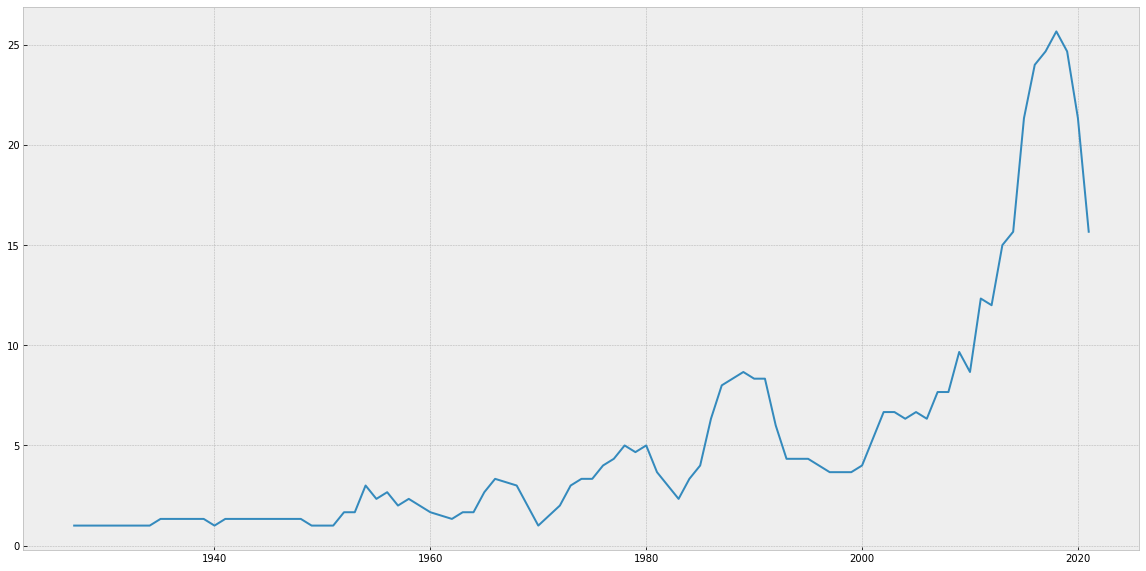

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

overall_freq = df['year'].value_counts().sort_index()
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(overall_freq.index, pd.Series(overall_freq.values).rolling(3).mean(), figure=fig)
plt.show()

In [8]:
top_genres = df['genres'].value_counts().head(8).index
unique_genres = set(
                ",".join(top_genres)
                   .strip()
                   .split(",")
                )
if '' in unique_genres:
    unique_genres.remove('')

unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Documentary',
 'Drama',
 'Science Fiction'}

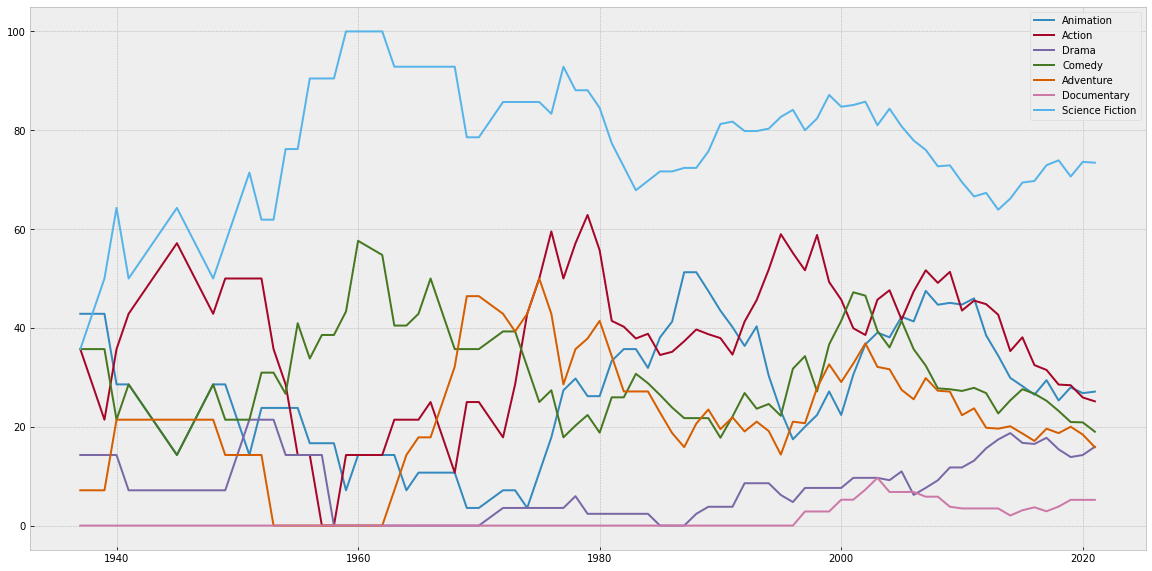

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

genre_percent_dict = {}
for genre in unique_genres:
    genre_df = df[df['genres'].str.contains(genre)]
    genre_freq = genre_df['year'].value_counts().sort_index()
    genre_percent = (genre_freq/overall_freq*100).fillna(0)
    genre_percent_dict[genre] = genre_percent
    ax.plot(overall_freq.index, genre_percent.rolling(7).mean(), label = genre)
ax.legend()
plt.show()

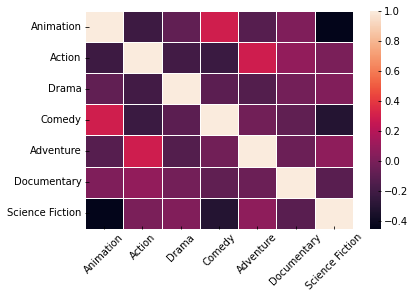

In [10]:
import numpy as np
import seaborn as sns

genre_list = []
percent_list = []
for genre in genre_percent_dict:
    genre_list.append(genre)
    percent_list.append(genre_percent_dict[genre])

corrs = np.corrcoef(percent_list)
sns.heatmap(corrs, linewidths=.5, xticklabels=genre_list, yticklabels=genre_list)
plt.xticks(rotation=45)
plt.show()

overview word cloud


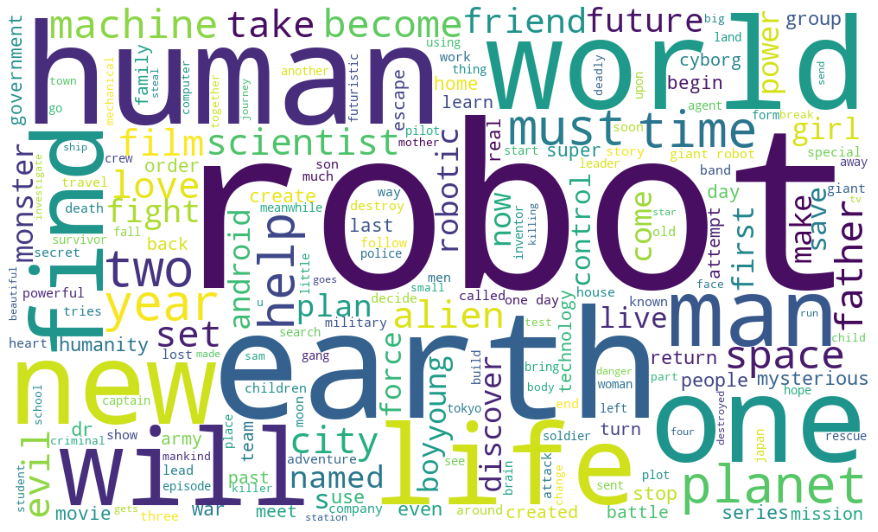

In [11]:
from wordcloud import WordCloud, STOPWORDS

overview_words = ''
stopwords = set(STOPWORDS)
text_cols = [
            # 'title',
            # 'tagline',
            'overview'
            ]
# iterate through the data
for col in text_cols:
    for val in df[col]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        overview_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1000, height = 600,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(overview_words)

    # plot the WordCloud image
    plt.figure(figsize = (12, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    print(col, 'word cloud')
    plt.show()

In [12]:
poster_df = df[df['poster_path'].notna()].sort_values('year')
poster_df = poster_df[['year', 'title', 'poster_path']].dropna()
poster_df['poster_path'] = poster_df['poster_path'].apply(lambda x: 'https://image.tmdb.org/t/p/w200{}'.format(x))

poster_df['year'] = poster_df['year'] // 10 * 10
poster_df.value_counts('year', sort=False)

year
1910.0      1
1920.0      1
1930.0      6
1940.0      5
1950.0     18
1960.0     15
1970.0     35
1980.0     55
1990.0     43
2000.0     66
2010.0    170
2020.0     25
dtype: int64

In [13]:
decades = poster_df['year'].unique()
source_dict = {}
for decade in decades:
    decade_df = poster_df[poster_df['year'] == decade]
    source_dict[decade] = list(decade_df['poster_path'].values)

In [14]:
import ipyplot

images = []
labels = []
for i in source_dict:
    for url in source_dict[i]:
        images.append(url)
        label = str(i)[:4]+'s'
        labels.append(label)

ipyplot.plot_class_tabs(images=images, labels=labels, max_imgs_per_tab=200, img_width=200)